University of Zagreb, Faculty of Electrical Engineering and Computing

## Imagination or Recollection? Discovering Differences in Cognitive Experience through Data Science


#### Fani Sentinella-Jerbić, 2022


Exploratory Data Analysis performed on [Hippocorpus](https://msropendata.com/datasets/0a83fb6f-a759-4a17-aaa2-fbac84577318) - a dataset of 6,854 English diary-like short stories about recalled and imagined events.




In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graph plotting
import seaborn as sns # beautify plots
import sklearn # machine learning
import matplotlib.pyplot as plt
import warnings
#import spacy

## Explanatory data analysis

In [2]:
df = pd.read_csv('hcV3-stories.csv')
stories = pd.read_csv('hippoCorpusV2.csv')
stories.shape

(6854, 23)

In [3]:
stories.columns.values 

array(['AssignmentId', 'WorkTimeInSeconds', 'WorkerId', 'annotatorAge',
       'annotatorGender', 'annotatorRace', 'distracted', 'draining',
       'frequency', 'importance', 'logTimeSinceEvent', 'mainEvent',
       'memType', 'mostSurprising', 'openness', 'recAgnPairId',
       'recImgPairId', 'similarity', 'similarityReason', 'story',
       'stressful', 'summary', 'timeSinceEvent'], dtype=object)

Text(0.5, 0, '')

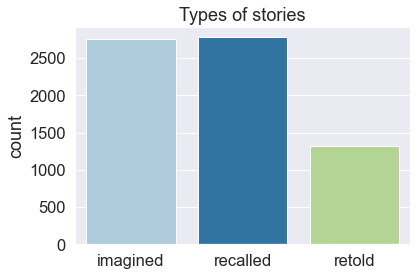

In [4]:
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.countplot(x="memType", data=stories, palette=sns.color_palette("Paired"))
plt.title('Types of stories')
plt.xlabel('')

In [5]:
stories[['mostSurprising', 'mainEvent']].head(8)

,mostSurprising,mainEvent
0,when I got concert tickets,attending a show
1,we saw the beautiful sky.,a concert.
2,she went into labor early,my sister having her twins a little early
3,finding out they were healthy.,meeting my twin niece and nephew.
4,When I don't answer the phone in case I owe th...,the consequences of going to burning man
5,that I had to borrow money from Quickstep.,about my journey this year to Burning Man meta...
6,Lynn pinched Eric's rear and his reaction.,a scary car ride where we swerved on our way t...
7,we got pulled over the cops because of our dri...,a bad driving experience on the way to Acadia ...


In [6]:
stories['annotatorAge'].mean()

33.5535060752452

In [7]:
stories['annotatorGender'].value_counts()

woman         3422
man           3363
na              31
nonBinary       23
transman        10
other            3
transwoman       2
Name: annotatorGender, dtype: int64

In [8]:
stories['annotatorRace'].value_counts()

white            5044
black             690
hisp              395
asian             390
other             162
na                 63
indian             44
native             43
middleEastern      13
islander           10
Name: annotatorRace, dtype: int64

The dataset contains lots of information which doesn't really contribute to the aim of this seminar. I'm dropping them.

In [9]:
stories = stories.drop(columns=['annotatorAge','annotatorGender', 'annotatorRace'])
stories = stories.drop(columns=['AssignmentId', 'WorkerId', 'recImgPairId', 'recAgnPairId'])

In [10]:
counts_by_features = stories.isna().sum()
features_with_na = counts_by_features[counts_by_features > 0]
features_with_na

frequency           2756
importance           144
similarity          4098
similarityReason    4098
dtype: int64

In [11]:
stories['frequency'] = stories['frequency'].fillna(0)
stories['importance'] = stories['importance'].fillna(0)

In [12]:
def countplot(ax, df, x):
    sns.set(font_scale = 2)
    sns.countplot(ax=ax, data=df, x=x, hue='memType', palette=sns.color_palette("Paired"))
    
def plots(df, features, func=countplot):
    tot = len(features)
    cols = 3
    rows = tot // cols + tot % cols
    position = range(1,tot + 1)
    
    fig = plt.figure(figsize=(20,10))
    i = 0
    for k in range(tot):
        ax = fig.add_subplot(rows, cols, position[k])
        func(ax, df, x=features[i])
        i += 1
    plt.tight_layout()
    plt.show()

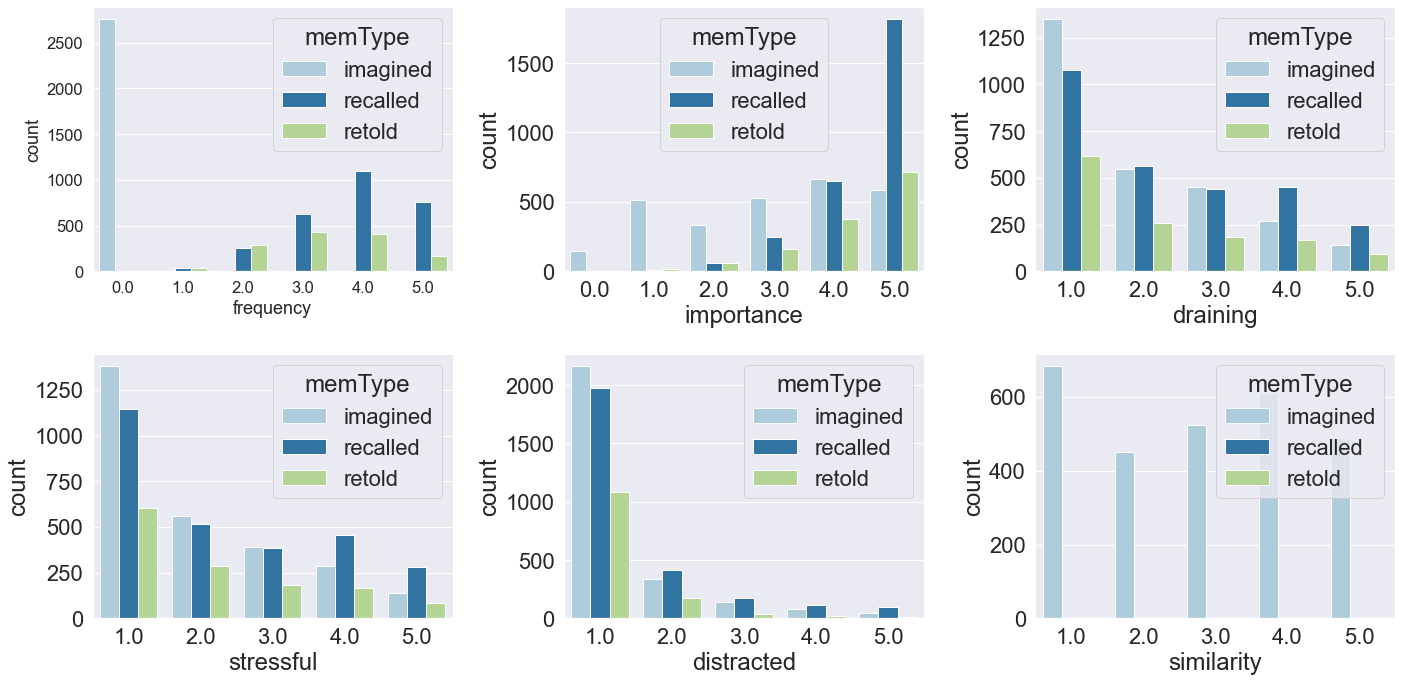

In [13]:
plots(stories, ['frequency', 'importance', 'draining', 'stressful', 'distracted', 'similarity'])

Although somewhat interesting, these features are very predictable and not available for most of texts "in the wild". I would like to obtain information only from the stories.

## Feature extraction

In [14]:
stories = stories[['story', 'memType']]
stories.head(10)

,story,memType
0,"Concerts are my most favorite thing, and my bo...",imagined
1,"The day started perfectly, with a great drive ...",recalled
2,It seems just like yesterday but today makes f...,imagined
3,"Five months ago, my niece and nephew were born...",recalled
4,About a month ago I went to burning man. I was...,imagined
5,Burning Man metamorphoses was perfect. I am de...,recalled
6,"Play stupid games, win stupid prizes road trip...",imagined
7,"Dear Diary,I would say this happened about 3 m...",recalled
8,I wanted to write about one of the best days i...,imagined
9,Me and my girlfriend had gone to the Los Angel...,retold


In [15]:
retold = stories[stories['memType'] == 'retold']
stories = stories.drop(retold.index)

In [16]:
stories['memType'] = np.where(stories['memType'] == 'recalled', 0, 1)
y = stories['memType']

In [17]:
stories.head()

,story,memType
0,"Concerts are my most favorite thing, and my bo...",1
1,"The day started perfectly, with a great drive ...",0
2,It seems just like yesterday but today makes f...,1
3,"Five months ago, my niece and nephew were born...",0
4,About a month ago I went to burning man. I was...,1


In order to achieve that I need to extract some features from the stories. 

In [18]:
import spacy
import math
from textblob import TextBlob

nlp = spacy.load("en_core_web_sm")

def lexical(df):
    df['chars'] = df['story'].str.len()
    df['split'] = df['story'].str.lower().str.split()
    df['words'] = df['split'].str.len()
    df['unique'] = df['story'].apply(lambda x: len(set(str(x).split())))
    df['uniqpct'] = df['unique']/df['words']
    df['polar'] = df['story'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subj'] = df['story'].apply(lambda x: TextBlob(x).sentiment.subjectivity) 
    df = selfrefsners(df)
    df['stoppct'] = df['stops']/df['words']
    
    return df

def selfrefsners(df):
    selfrefs = []
    ners = []
    sents = []
    stops = []
    divs = []
    for i in range(0, df.shape[0]):
        storyarr = df['split'].iloc[i]
        
        # personal words count
        countI = storyarr.count('i')
        countMe = storyarr.count('me')
        countMy = storyarr.count('my')
        count = countI + countMe + countMy
        selfrefs.append(count)
        
        # sentence and named entity count
        story = df['story'].iloc[i]
        doc = nlp(story)
        countNER = len(doc.ents)
        countSENT = len([x for x in doc.sents])
        ners.append(countNER)
        sents.append(countSENT)
        
        # stopwords count
        countSTOP = 0
        for token in doc:
            if token.is_stop:
                countSTOP += 1
        stops.append(countSTOP)
        
        # lexical diversity
        words = set(storyarr)
        div = 0
        for word in words:
            freqword = storyarr.count(word)
            lenstory = df['words'].iloc[i]
            div -= freqword/lenstory * math.log(freqword/lenstory, 2)
        divs.append(div)  
        
        
    df['selfRef'] = selfrefs
    df['ners'] = ners
    df['sents'] = sents
    df['stops'] = stops
    df['divs'] = divs
    return df

def ners(df):
    ners = []
    for i in range(0, df.shape[0]):
        story = df['story'].iloc[i]
        doc = nlp(story)
        count = len(doc.ents)
        ners.append(count)
    df['ner'] = ners
    return df

stories = lexical(stories)
retold = lexical(retold)

In [19]:
stories.to_csv('stories-lex.csv', index=False)
retold.to_csv('retold-lex.csv', index=False)

In [20]:
stories = pd.read_csv('stories-lex.csv')
retold = pd.read_csv('retold-lex.csv')

## Statistical testing

In [21]:
stories.groupby('memType').describe()

chars                                                           \
          count         mean         std    min     25%     50%      75%   
memType                                                                    
0        2779.0  1432.454480  466.782603  604.0  1091.0  1360.0  1698.50   
1        2756.0  1253.879173  454.338395  600.0   922.0  1188.0  1486.25   

                  words              ...      divs           stoppct  \
            max   count        mean  ...       75%       max   count   
memType                              ...                               
0        2999.0  2779.0  277.973372  ...  6.897055  7.658740  2779.0   
1        2999.0  2756.0  244.736212  ...  6.828594  7.570368  2756.0   

                                                                               
             mean       std       min       25%       50%       75%       max  
memType                                                                        
0        0.632723  0.041607  0.452514  0.607143  0.634218  0.660272  0.777251  
1        0.640452  0.043842  0.429752  0.612364  0.641065  0.668658  0.798561  

[2 rows x 96 columns]

In [22]:
from scipy import stats
import statsmodels.api as sm
sns.set(font_scale = 1)

def pvalue_msg(pvalue, alpha):
    return ' ' if pvalue > alpha else ' NOT '

def t_test(data, feature, alpha):
    fe = stories[feature]
    fe0 = fe[data['memType']==0]
    fe1 = fe[data['memType']==1]
    
    print(feature.upper())
    print('')
    print('NORMALITY SHAPIRO')
    p = stats.shapiro(fe0).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}')
    p = stats.shapiro(fe1).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}\n')
    
    print('NORMALITY DAGOSTINOS K2')
    p = stats.normaltest(fe0).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}')
    p = stats.normaltest(fe1).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}\n')
    
    print('HOMOGENEITY LEVENE')
    pl = stats.levene(fe0, fe1).pvalue
    print(f'variances are{ pvalue_msg(pl, alpha)}homogenous, pvalue={pl}\n')
    
    print('HOMOGENEITY BARTLETT')
    pb = stats.bartlett(fe0, fe1).pvalue
    print(f'variances are{ pvalue_msg(pb, alpha)}homogenous, pvalue={pb}\n')
    
    equalvars = pl > alpha or pb > alpha
    
    sns.displot(kde=True, data=data, x=feature, hue="memType", multiple="stack", palette=sns.color_palette("Paired", n_colors=2))
    #plt.title('HISTOGRAM AND DENSITY PLOT')
    plt.savefig('hist-' + feature + '.png', dpi=300)
    plt.show()
    
    fig, (ax0, ax1) = plt.subplots(1,2)
    plt.suptitle(feature)
    fe0z = stats.zscore(fe0)
    sm.qqplot(fe0z, line='45', markerfacecolor='#3274a1', markeredgecolor='#3274a1', ax=ax0)
    ax0.set_title('recalled')
    
    fe1z = stats.zscore(fe1)
    sm.qqplot(fe1z, line='45', markerfacecolor='#3274a1', markeredgecolor='#3274a1', ax=ax1)
    ax1.set_title('imagined')
    
    fig.tight_layout()
    plt.savefig('qq-' + feature + '.png', dpi=300)
    plt.show()
    
    p = stats.ttest_ind(fe0, fe1, equal_var=equalvars).pvalue
    
    print('TWO SAMPLE T-TEST')
    print(f'stories do{pvalue_msg(p,alpha)}statistically differ in terms of mean {feature}, pvalue={p}')
    
    print('\n\n\n\n')

In [40]:
X = stories.drop(columns=['story', 'split'])
X_retold = retold.drop(columns=['story', 'split'])
X.head()

,memType,chars,words,unique,uniqpct,polar,subj,selfRef,ners,sents,stops,divs,stoppct
0,1,1059,203,127,0.625616,0.308556,0.576111,18,2,15,133,6.524977,0.655172
1,0,902,183,108,0.590164,0.485859,0.654444,12,4,16,122,6.237080,0.666667
2,1,1330,266,152,0.571429,0.209031,0.508251,24,9,21,168,6.590520,0.631579
3,0,876,165,106,0.642424,0.140360,0.593561,15,5,15,106,6.274148,0.642424
4,1,783,162,104,0.641975,0.029312,0.314161,20,3,15,97,6.267988,0.598765


CHARS

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=3.5448673778628755e-28
sample is NOT normally distributed, pvalue=3.65734672431368e-32

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=9.327321833106233e-58
sample is NOT normally distributed, pvalue=2.828682627244185e-80

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.028778091687080346

HOMOGENEITY BARTLETT
variances are homogenous, pvalue=0.15532383208801123



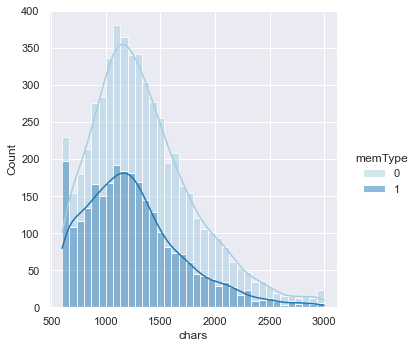

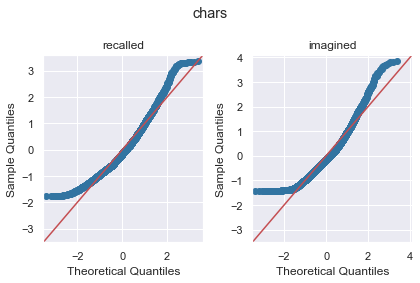

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean chars, pvalue=2.61646138596804e-46





WORDS

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=2.7617103549134095e-27
sample is NOT normally distributed, pvalue=6.773978977686967e-32

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=1.1556270321353213e-56
sample is NOT normally distributed, pvalue=1.8638257033957752e-80

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.027047755461166785

HOMOGENEITY BARTLETT
variances are homogenous, pvalue=0.13271402903032245



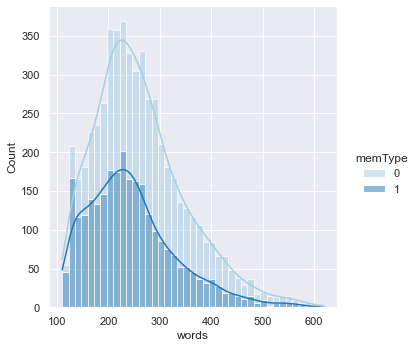

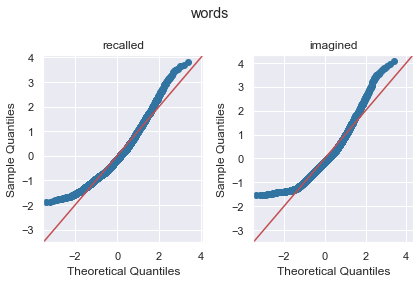

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean words, pvalue=4.1338415056840517e-44





UNIQUE

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=3.81790341213e-21
sample is NOT normally distributed, pvalue=2.563579427497542e-24

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=6.469271347665256e-33
sample is NOT normally distributed, pvalue=4.569590729559469e-43

HOMOGENEITY LEVENE
variances are homogenous, pvalue=0.9497941771563091

HOMOGENEITY BARTLETT
variances are homogenous, pvalue=0.6576648087995771



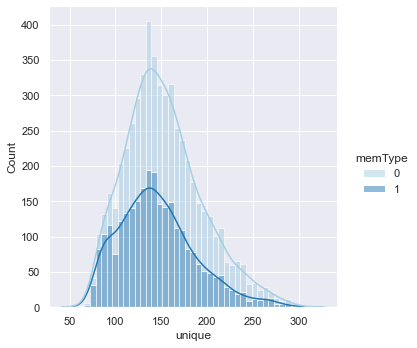

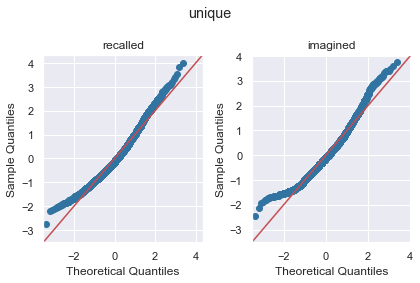

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean unique, pvalue=1.5847701702480681e-34





UNIQPCT

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=0.00010658079554559663
sample is NOT normally distributed, pvalue=3.0671964967865506e-09

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=0.0003198277115056394
sample is NOT normally distributed, pvalue=2.1358221887173858e-18

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.04265359121687878

HOMOGENEITY BARTLETT
variances are NOT homogenous, pvalue=0.012523029409513331



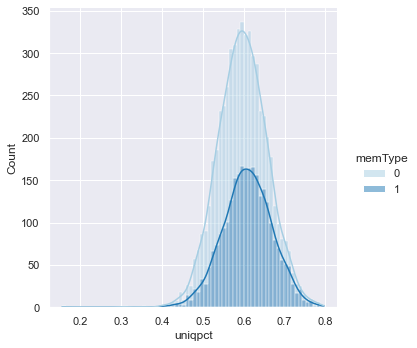

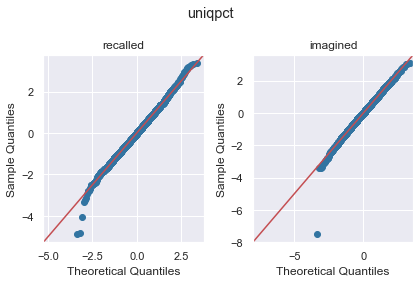

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean uniqpct, pvalue=5.749080858807633e-47





POLAR

NORMALITY SHAPIRO
sample is normally distributed, pvalue=0.05076773092150688
sample is normally distributed, pvalue=0.0665118545293808

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=0.02965665743226468
sample is NOT normally distributed, pvalue=0.016182732989334023

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.030750153399646492

HOMOGENEITY BARTLETT
variances are NOT homogenous, pvalue=0.0035552614481178866



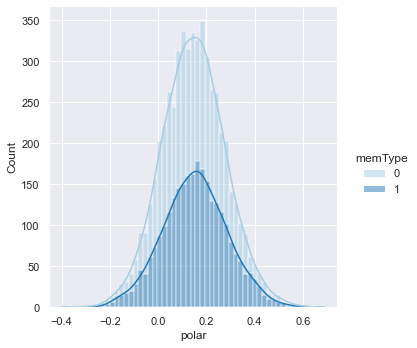

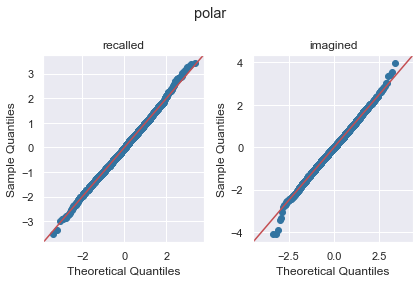

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean polar, pvalue=0.002261717280729005





SUBJ

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=0.003302008844912052
sample is NOT normally distributed, pvalue=0.0010344706242904067

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=0.0011123857029056935
sample is NOT normally distributed, pvalue=0.0005990243444088009

HOMOGENEITY LEVENE
variances are homogenous, pvalue=0.9182513350791357

HOMOGENEITY BARTLETT
variances are homogenous, pvalue=0.6639665697497393



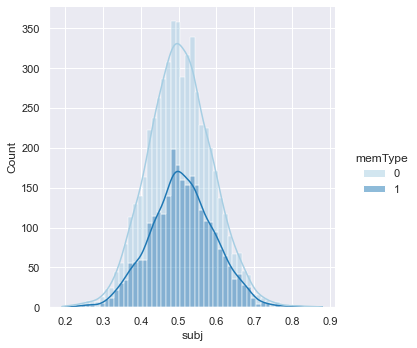

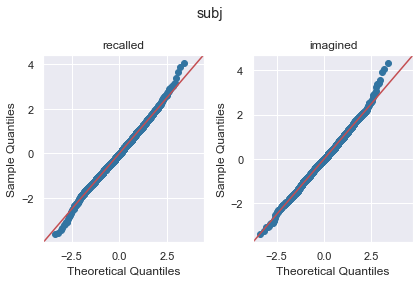

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean subj, pvalue=2.0925657452668735e-08





SELFREF

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=8.789534748765922e-24
sample is NOT normally distributed, pvalue=1.0345449319158895e-26

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=1.0731489422696812e-45
sample is NOT normally distributed, pvalue=1.11511974045585e-69

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.01120097138450681

HOMOGENEITY BARTLETT
variances are homogenous, pvalue=0.05765453573361728



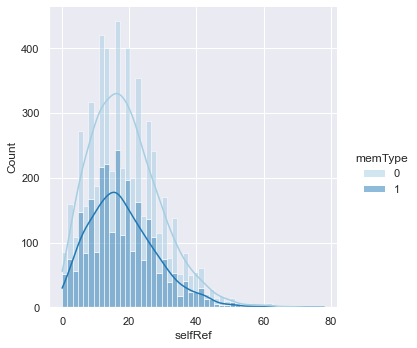

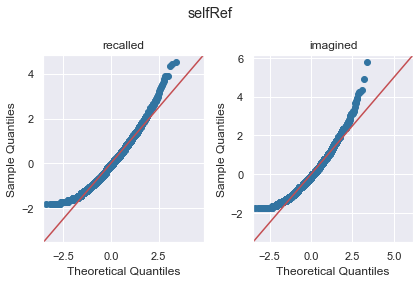

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean selfRef, pvalue=1.2312490695388217e-05





NERS

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=1.309933804450839e-41
sample is NOT normally distributed, pvalue=0.0

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=8.946025813640872e-209
sample is NOT normally distributed, pvalue=5.205293186998666e-271

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=4.398978499226898e-08

HOMOGENEITY BARTLETT
variances are NOT homogenous, pvalue=3.560413859517069e-11



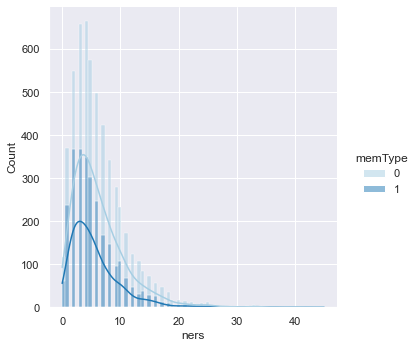

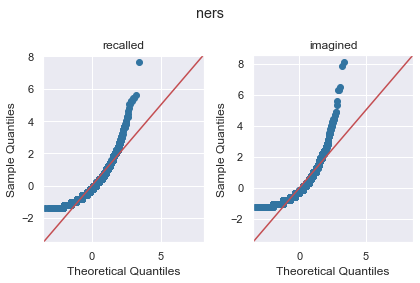

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean ners, pvalue=2.216100145729534e-32





SENTS

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=1.401298464324817e-45
sample is NOT normally distributed, pvalue=0.0

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=3.549523407301312e-114
sample is NOT normally distributed, pvalue=1.2037765496270926e-134

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.0069841034865754815

HOMOGENEITY BARTLETT
variances are NOT homogenous, pvalue=0.0039434471696571894



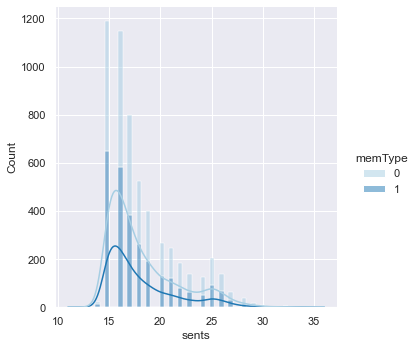

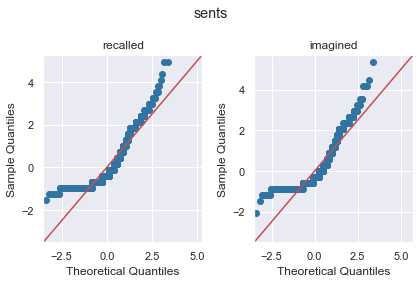

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean sents, pvalue=4.8224123157032076e-05





STOPS

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=1.0061836105176453e-26
sample is NOT normally distributed, pvalue=1.3646535852029371e-30

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=9.276502692828973e-59
sample is NOT normally distributed, pvalue=1.5762785376254343e-83

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.010466521557482846

HOMOGENEITY BARTLETT
variances are NOT homogenous, pvalue=0.04231483671409357



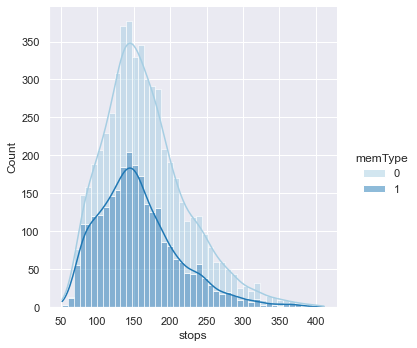

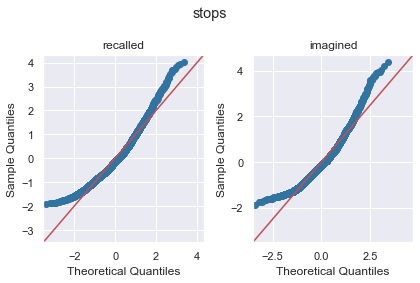

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean stops, pvalue=2.4762303943351146e-36





DIVS

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=3.53029026882723e-05
sample is NOT normally distributed, pvalue=8.89221098532289e-07

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=7.568412756454419e-05
sample is NOT normally distributed, pvalue=2.7425825746788816e-05

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=2.0985603912428237e-09

HOMOGENEITY BARTLETT
variances are NOT homogenous, pvalue=9.693206644927107e-10



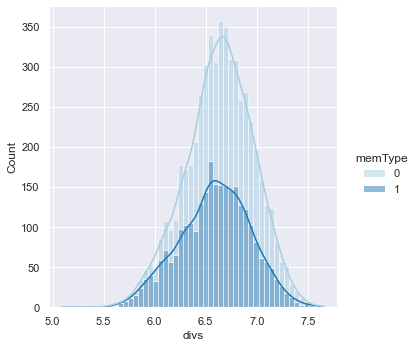

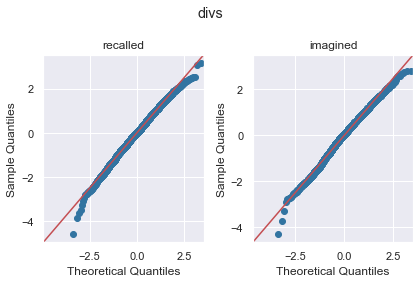

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean divs, pvalue=1.4072959059371334e-25





STOPPCT

NORMALITY SHAPIRO
sample is NOT normally distributed, pvalue=2.63356572105522e-08
sample is NOT normally distributed, pvalue=1.5288595278661887e-08

NORMALITY DAGOSTINOS K2
sample is NOT normally distributed, pvalue=2.0071567137337894e-12
sample is NOT normally distributed, pvalue=4.2970950441205336e-13

HOMOGENEITY LEVENE
variances are NOT homogenous, pvalue=0.007420679183064717

HOMOGENEITY BARTLETT
variances are NOT homogenous, pvalue=0.00592565313695358



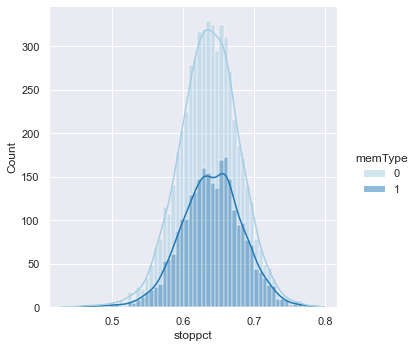

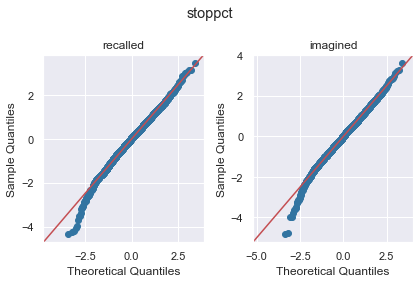

TWO SAMPLE T-TEST
stories do NOT statistically differ in terms of mean stoppct, pvalue=1.916753026854794e-11







In [41]:
import warnings
warnings.filterwarnings('ignore')

for f in X.columns.values:
    if f != 'memType':
        t_test(stories, f, 0.05)

In [25]:
X = X.drop(columns=['memType'])
X_retold = X_retold.drop(columns=['memType'])
X_retold.head()

,chars,words,unique,uniqpct,polar,subj,selfRef,ners,sents,stops,divs,stoppct
0,1518,299,158,0.528428,0.197619,0.444048,16,10,26,181,6.571339,0.605351
1,2119,374,236,0.631016,0.190260,0.554113,7,11,22,229,7.293915,0.612299
2,1049,205,117,0.570732,0.063069,0.495899,19,6,16,130,6.288707,0.634146
3,1827,339,196,0.578171,0.128431,0.454412,4,11,19,205,6.997806,0.604720
4,1022,210,122,0.580952,0.376913,0.538690,20,3,17,144,6.353371,0.685714


## Machine Learning
I'm going to train a machine learning model to classify stories into imagined and recalled. Then I'll ask the model to predict whether recalled stories are imagined or recalled. This could explain narrativization of recalled events.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
sclr = StandardScaler()
X_train = pd.DataFrame(sclr.fit_transform(X_train), columns=X_train.columns)

## Choosing models & hyperparameters

In [27]:
from sklearn.model_selection import GridSearchCV
def grid_search(model, params, X, y):
    model = GridSearchCV(model, params, n_jobs=-1)
    model.fit(X, y)
    return model

### Logistic regression

In [28]:
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
hp = {
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'penalty': ['none', 'l1', 'l2', 'elasticnet'],
        'C': [0.1, 1, 10, 100],
}
lr = grid_search(LogisticRegression(), hp, X_train, y_train).best_params_

### K-neighbors classifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier
hp = {
        'n_neighbors': list(range(1, 15)),
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
}
knn = grid_search(KNeighborsClassifier(), hp, X_train, y_train).best_params_

### Decision tree classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier
hp = {
        'ccp_alpha': [0.1, 0.01, 0.001, 0.0001, 0],
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 6, 7, 8, 9, 10, None],
        'max_features': ['auto', 'sqrt', 'log2']
}
dt = grid_search(DecisionTreeClassifier(), hp, X_train, y_train).best_params_

In [31]:
import wittgenstein as lw

model = lw.RIPPER()
model.fit(X_train, y_train)
model.ruleset_.out_pretty()

[[chars=<-1.17 ^ ners=-0.91--0.69 ^ subj=>1.27 ^ selfRef=-0.37--0.084] V
[chars=<-1.17 ^ divs=<-1.35 ^ stoppct=0.26-0.52] V
[ners=-0.91--0.69 ^ words=-0.38--0.16 ^ sents=0.23-0.81] V
[chars=<-1.17] V
[ners=-0.91--0.69 ^ stops=-0.37--0.17] V
[chars=-1.17--0.85 ^ stops=-0.84--0.58] V
[uniqpct=>1.27]]


### Random forest classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
hp = {
        'n_estimators': [50, 200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion': ['gini', 'entropy'],
}
rf = grid_search(RandomForestClassifier(), hp, X_train, y_train).best_params_

In [33]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

table = ['Algorithm', 'Fold1', 'Fold2', 'Fold3','Fold4', 'Fold5', 'Average']

def cross_validate(X, y, models):
    cv = KFold(n_splits=5, random_state=5, shuffle=True)
    all_rows = []
    for m in models:
        row = []
        row.append(type(m).__name__)
        print(type(m).__name__)
        scores = cross_val_score(m, X, y, cv=cv, n_jobs=-1, scoring='f1')
        if "GridSearchCV" == type(m).__name__:
            print(m.fit(X).best_params_)
        for score in scores:
            row.append(score)
        row.append(sum(scores)/len(scores))
        all_rows.append(row)
    res = pd.DataFrame(all_rows, columns=table)
    display(res)

models = [LogisticRegression(**lr),
          KNeighborsClassifier(**knn),
          SVC(),
          DecisionTreeClassifier(**dt),
          RandomForestClassifier(),
         ]
cross_validate(X, y, models)

LogisticRegression
KNeighborsClassifier
SVC
DecisionTreeClassifier
RandomForestClassifier


,Algorithm,Fold1,Fold2,Fold3,Fold4,Fold5,Average
0,LogisticRegression,0.630282,0.606061,0.613357,0.632391,0.647746,0.625967
1,KNeighborsClassifier,0.516194,0.534430,0.521649,0.503553,0.552529,0.525671
2,SVC,0.536729,0.556079,0.538462,0.532389,0.586859,0.550103
3,DecisionTreeClassifier,0.564500,0.539461,0.582968,0.565854,0.550584,0.560673
4,RandomForestClassifier,0.579044,0.576960,0.555235,0.565714,0.595588,0.574508


In [34]:
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(**lr).fit(X_train,y_train)
accuracy_score(y_train, logreg.predict(X_train))

0.609009877138039

In [37]:
logreg.predict(sclr.transform(X_retold)).mean()

0.4162244124336619

         chars
0     0.634593
1    -0.081558
2     0.764997
3     0.538394
4    -0.620275
...        ...
4146 -1.501034
4147  0.025330
4148 -0.601035
4149 -0.387258
4150  2.560719

[4151 rows x 1 columns]
0.5825102384967478


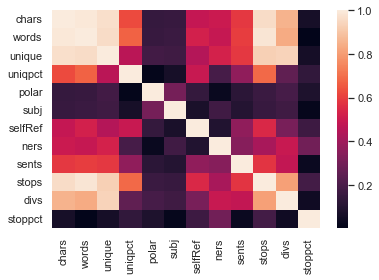

In [38]:
from sklearn.feature_selection import SelectKBest
sns.heatmap(abs(X.corr()))
sel = SelectKBest(k=1)
X_new = sel.fit_transform(X_train, y_train)
cols = sel.get_support()
print(X_train.iloc[:,cols])
logreg = LogisticRegression(**lr).fit(X_new,y_train)
print(accuracy_score(y_train, logreg.predict(X_new)))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


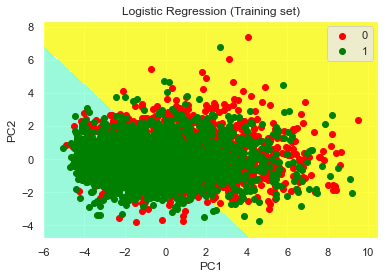

In [39]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 2)
 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
explained_variance = pca.explained_variance_ratio_

clf = LogisticRegression()
clf.fit(X_train, y_train)

from matplotlib.colors import ListedColormap
 
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
 
plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
 
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
 
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
 
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend()
plt.show()